# Sentiment Analysis: Spotify Review App

Regarding the data, the dataset was taken from Kaggle. This is a dataset for __binary sentiment classification__.

Basically a basic sentiment analysis problem, as in this case, consists of a classification problem, where the possible output labels are: `positive` and `negative`. Which indicates, if the review of a Spotify App speaks positively or negatively. In our case it is a binary problem, but one could have many more "feelings" tagged and thus allow a more granular analysis.

### These are the objectives of the project:

* Put together a set of preprocessing functions that we can use later on any NLP or related problems.
* Vectorize the data in order to apply a machine learning model to it: using BoW, TF-IDF or Word2Vec.
* Train a sentiment analysis model that allows us to detect positive, negative and neutral opinions in movie reviews.

---
## 1. Get the data

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display
import warnings
import time
import math
import joblib
from scipy import sparse
%matplotlib inline

In [172]:
data = pd.read_csv("/Users/carolinapeinado/Desktop/Santi/SpotifyAppReviews/files/reviews.csv")

In [173]:
data

,Time_submitted,Review,Rating,Total_thumbsup,Reply
0,2022-07-09 15:00:00,"Great music service, the audio is high quality...",5,2,NaN
1,2022-07-09 14:21:22,Please ignore previous negative rating. This a...,5,1,NaN
2,2022-07-09 13:27:32,"This pop-up ""Get the best Spotify experience o...",4,0,NaN
3,2022-07-09 13:26:45,Really buggy and terrible to use as of recently,1,1,NaN
4,2022-07-09 13:20:49,Dear Spotify why do I get songs that I didn't ...,1,1,NaN
...,...,...,...,...,...
61589,2022-01-01 03:01:29,Even though it was communicated that lyrics fe...,1,6,NaN
61590,2022-01-01 02:13:40,"Use to be sooo good back when I had it, and wh...",1,0,NaN
61591,2022-01-01 01:02:29,This app would be good if not for it taking ov...,2,10,NaN
61592,2022-01-01 00:49:23,The app is good hard to navigate and won't jus...,2,1,NaN


---
## 2. Data Analysis and Pre-Procesing

In [174]:
print("BASIC INFO")
print('-'*20,"\n")
print("The shape of the dataset is:",data.shape,"\n")
columns = list(data.columns)

data_0 = data.copy()
print("Percentage of missing values")
data_0 = data_0.dropna().reset_index(drop=True)
empties = data_0.isna().sum()
empties_sort = empties.sort_values(ascending= False) 
empties_sort_per = (empties_sort/len(data_0))
print(empties_sort_per,"\n")

print("The columns of the dataset are:",columns,"\n")
for i in range(len(columns)):
  print(f"The type of {columns[i]} column is:", data[str(columns[i])].dtypes)

BASIC INFO
-------------------- 

The shape of the dataset is: (61594, 5) 

Percentage of missing values
Time_submitted    0.0
Review            0.0
Rating            0.0
Total_thumbsup    0.0
Reply             0.0
dtype: float64 

The columns of the dataset are: ['Time_submitted', 'Review', 'Rating', 'Total_thumbsup', 'Reply'] 

The type of Time_submitted column is: object
The type of Review column is: object
The type of Rating column is: int64
The type of Total_thumbsup column is: int64
The type of Reply column is: object


In [175]:
#Let´s analyze the amount of duplicates on the "Review" column..
data.drop_duplicates(subset=["Review"], keep="first", inplace=True)
data["Review"].describe()

count                                                 61356
unique                                                61356
top       Great music service, the audio is high quality...
freq                                                      1
Name: Review, dtype: object

We have 61356 Reviews, each one of them different. It seems, that the Time when the Review was made and wheter if was a Reply from Spotify or not and the ampunt of thumbup it won´t give me much of useful information for further Analysis, hence I am going to eliminate both columns to continue with the EDA.

In [176]:
del data["Reply"]
del data["Time_submitted"]
del data["Total_thumbsup"]
data

,Review,Rating
0,"Great music service, the audio is high quality...",5
1,Please ignore previous negative rating. This a...,5
2,"This pop-up ""Get the best Spotify experience o...",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't ...,1
...,...,...
61589,Even though it was communicated that lyrics fe...,1
61590,"Use to be sooo good back when I had it, and wh...",1
61591,This app would be good if not for it taking ov...,2
61592,The app is good hard to navigate and won't jus...,2


Basic Info of the Rating feedback...
5    21941
1    17610
4     7821
2     7108
3     6876
Name: Rating, dtype: int64 



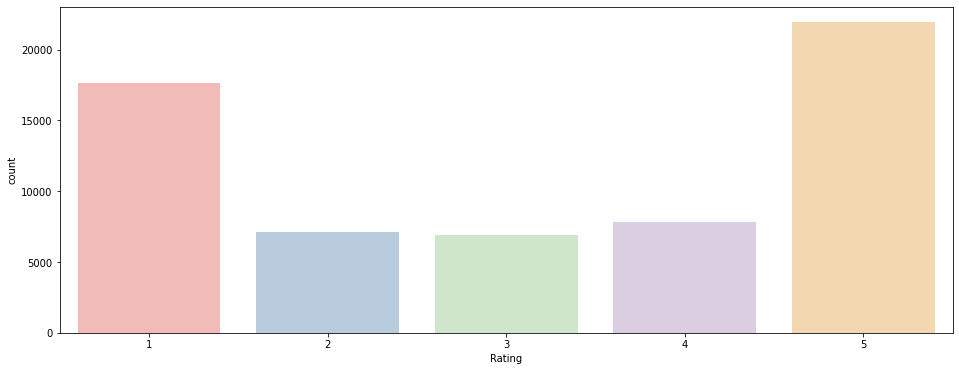

The percentage of the value 1 is of 28.7 % 

The percentage of the value 2 is of 11.58 % 

The percentage of the value 3 is of 11.21 % 

The percentage of the value 4 is of 12.75 % 

The percentage of the value 5 is of 35.76 % 



In [177]:
print("Basic Info of the Rating feedback...")
a = data["Rating"].value_counts()
print(a,"\n")
plt.figure(figsize=(16,6))
sns.countplot(data=data, x="Rating", palette='Pastel1')
plt.show()

total = data.shape[0]
for i in range(6):
  if i != 0:
    percentage = a[i]/total
    print(f"The percentage of the value {i} is of",round(percentage,4)*100,"%","\n")


I´am going to "tranform" this problem into a simpler problem, which was the objective of it once started... In order to do this, the "Rating" column should be tranform. 
The reviews with 4 or 5 stars will be considered as positive, the ones with 1 or 2 as negative and the ones with 3 as neutral. 

In [178]:
for index, column in data.iterrows():
  if data.loc[index, "Rating"] == 1 or data.loc[index, "Rating"] == 2:
    data.loc[index, "Rating"] = "Negative"
  elif data.loc[index, "Rating"] == 3:
    data.loc[index, "Rating"] = "Neutral"
  else:
    data.loc[index, "Rating"] = "Positive"

data

,Review,Rating
0,"Great music service, the audio is high quality...",Positive
1,Please ignore previous negative rating. This a...,Positive
2,"This pop-up ""Get the best Spotify experience o...",Positive
3,Really buggy and terrible to use as of recently,Negative
4,Dear Spotify why do I get songs that I didn't ...,Negative
...,...,...
61589,Even though it was communicated that lyrics fe...,Negative
61590,"Use to be sooo good back when I had it, and wh...",Negative
61591,This app would be good if not for it taking ov...,Negative
61592,The app is good hard to navigate and won't jus...,Negative


# Let´s "clean" the text from the Review column...

In [179]:
import text_normalizer

In [180]:
for index,column in data.iterrows():
  data.loc[index,"Review"] = text_normalizer.clean_text(
    text=data.loc[index,"Review"],
    puncts=True,
    stopwords=True,
    urls=True,
    emails=True,
    numbers=True,
    emojis=True,
    special_char=True,
    phone_num=True,
    non_ascii=True,
    multiple_whitespaces=True,
    contractions=True,
    currency_symbols=True,
    custom_pattern=None,
  )
  data.loc[index,"Review"] = text_normalizer.lemmatize_text(data.loc[index,"Review"])

In [181]:
data

,Review,Rating
0,great music service audio high quality app eas...,Positive
1,ignore previous negative rating app super grea...,Positive
2,popup well spotify experience android annoying...,Positive
3,buggy terrible use recently,Negative
4,dear spotify song do not playlist shuffle play,Negative
...,...,...
61589,communicate lyric feature available user globa...,Negative
61590,use sooo good download free version could not ...,Negative
61591,app good take device start comp there s spotif...,Negative
61592,app good hard navigate will not let play song ...,Negative


In [182]:
data.to_csv("df_cleaned.csv")

In [125]:
data = pd.read_csv("/Users/carolinapeinado/Desktop/Santi/SpotifyAppReviews/files/df_cleaned.csv", index_col=0)

# Quick Analysis of the text/words on the column "Review"

In [183]:
from wordcloud import WordCloud

In [184]:
# Generating the respective texts for each particular sentiment analysis
positive_text = []
negative_text = []
neutral_text  = []
for index, columns in data.iterrows():
    if data.loc[index,"Rating"] == "Positive":
        positive_text.append(data.loc[index,"Review"])
    elif data.loc[index,"Rating"] == "Neutral":
        neutral_text.append(data.loc[index,"Review"])
    else:
        negative_text.append(data.loc[index,"Review"])

positive_text = str(positive_text)
negative_text = str(negative_text)
neutral_text  = str(neutral_text)

POSOTIVE REVIEWS


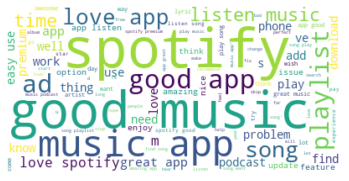

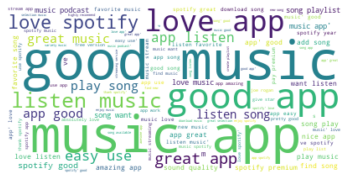

NEGATIVE REVIEWS


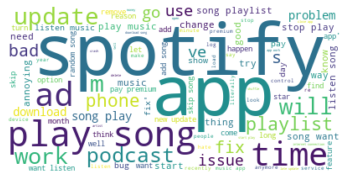

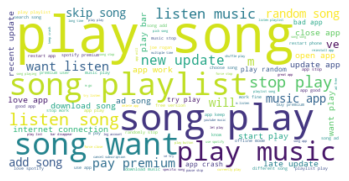

NEUTRAL REVIEWS


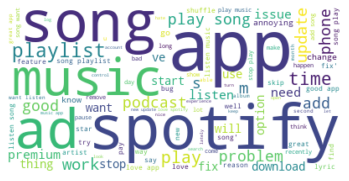

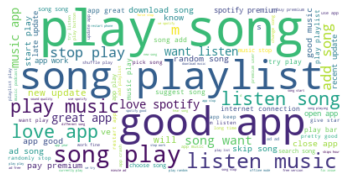

In [185]:
def show_wordcloud(text, sent):
    print(sent)
    #WordClod of just 1 word
    wordcloud = WordCloud( max_words=100, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    #WordCloud of two words
    wordcloud_2 = WordCloud(collocation_threshold = 2, collocations= True, max_words=100, background_color="white").generate(text)
    plt.imshow(wordcloud_2, interpolation='bilinear')
    plt.axis("off")
    plt.show()

sents = ["POSOTIVE REVIEWS", "NEGATIVE REVIEWS", "NEUTRAL REVIEWS"]
texts = [positive_text, negative_text, neutral_text]
for i in range(len(texts)):
    show_wordcloud(texts[i], sents[i])

# OneHotEncoding the Non-Numeric Variables

In [187]:
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.simplefilter("ignore")

In [188]:
#OneHotEnconding
def encoding(df, col_list):
  encoder = OneHotEncoder().fit(df[col_list])
  df = pd.concat(
      [
          df,
          pd.DataFrame(
              encoder.transform(df[col_list]).toarray(),
              index=df.index,
              columns=encoder.get_feature_names(col_list)
          )
      ],
      axis=1
  )

  df.drop(["Rating"], axis=1, inplace=True)

  return df

In [189]:
#Function Call
col_list = ["Rating"]
data = encoding(data, col_list)

#Transforming new columns into integers
data = data.astype({"Rating_Positive": int, "Rating_Negative": int, "Rating_Neutral":int})

data

,Review,Rating_Negative,Rating_Neutral,Rating_Positive
0,great music service audio high quality app eas...,0,0,1
1,ignore previous negative rating app super grea...,0,0,1
2,popup well spotify experience android annoying...,0,0,1
3,buggy terrible use recently,1,0,0
4,dear spotify song do not playlist shuffle play,1,0,0
...,...,...,...,...
61589,communicate lyric feature available user globa...,1,0,0
61590,use sooo good download free version could not ...,1,0,0
61591,app good take device start comp there s spotif...,1,0,0
61592,app good hard navigate will not let play song ...,1,0,0


In [191]:
data.to_csv("df_def.csv")

In [190]:
from sklearn.model_selection import train_test_split

In [192]:
X = data["Review"]
y = data.drop(["Review"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, shuffle=True, stratify=y, random_state=27)

In [193]:
#Quick chek over the shapes of the divided Data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(42949,)
(18407,)
(42949, 3)
(18407, 3)


---
## 3. Feature Engineering

For this step we have a variaty of options to choose. It is known by now that the best, in general terms, is using some of the Word Embedding already created from the big corporations such as Word2Vec(Google) or GloVe(Stanford). Also, I could make my own Embedding with the Gensim Library. There are several options, one more "expensive" (computationally speaking) than the other but also more effective. A good practive would be trying some of them and make a comparison...

In [158]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [194]:
#Bow/CountVectorizer
X_train_bow = X_train.copy()
X_test_bow  = X_test.copy()

bow_vectorizer = CountVectorizer(ngram_range=(1,2), max_features=1500)
bow_train_vect = bow_vectorizer.fit_transform(X_train_bow.values.astype('U'))
bow_test_vect  = bow_vectorizer.transform(X_test_bow.values.astype('U'))

#Tf-Idf
X_train_tfidf = X_train.copy()
X_test_tfidf  = X_test.copy()

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1500)
tfidf_train_vect = tfidf_vectorizer.fit_transform(X_train_tfidf.values.astype('U'))
tfidf_test_vect  = tfidf_vectorizer.transform(X_test_tfidf.values.astype('U'))

In [195]:
feature_names_bow = bow_vectorizer.get_feature_names()
feature_names_tfidf = tfidf_vectorizer.get_feature_names()

#Let´s quickly see how many of these 1500 most frequents words/n-grams coincide between these two different vectorizer method, the "logical" thing would be the entire 1500 because the corpus is the same....
def intersection(lst1, lst2):
    return len(list(set(lst1) & set(lst2)))
 

print(intersection(feature_names_bow, feature_names_tfidf))

1500


# Understanding the Sparse Matrix formed and showing the difference between the selected Vectorizers

In [196]:
from IPython.display import display, HTML

Both Matrixes have 42949 rows with 1500 columns, one per word/n-gram. The only difference is that the BoW Matrix values in it are integres (because it counts how many times the word/n-gram appears on the document) and on the Tf-Idf Matrix they are floats as it is a calculation on how important is the that word/n-gram in the corpus in comparison to others.

In [197]:
bow_train_vect

<42949x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 620193 stored elements in Compressed Sparse Row format>

In [198]:
tfidf_train_vect

<42949x1500 sparse matrix of type '<class 'numpy.float64'>'
	with 620193 stored elements in Compressed Sparse Row format>

In [199]:
#Shapes should match...
print(bow_train_vect.shape)
print(tfidf_train_vect.shape)

(42949, 1500)
(42949, 1500)


Let´s begin analysing the logic underneath the BoW Matrix

In [200]:
print(bow_train_vect)

  (0, 194)	1
  (0, 787)	1
  (0, 309)	1
  (0, 725)	1
  (0, 906)	1
  (0, 145)	1
  (0, 239)	1
  (0, 175)	1
  (0, 506)	1
  (0, 1224)	1
  (0, 1088)	1
  (0, 152)	1
  (0, 410)	1
  (0, 195)	1
  (0, 748)	1
  (0, 240)	1
  (1, 906)	1
  (1, 145)	1
  (1, 1080)	1
  (1, 31)	1
  (1, 1157)	1
  (1, 598)	1
  (1, 940)	1
  (1, 857)	1
  (1, 36)	1
  :	:
  (42946, 952)	1
  (42946, 1025)	1
  (42947, 194)	1
  (42947, 787)	1
  (42947, 195)	1
  (42947, 64)	1
  (42947, 623)	1
  (42947, 56)	1
  (42947, 958)	1
  (42947, 937)	2
  (42947, 774)	2
  (42947, 1442)	1
  (42947, 59)	1
  (42947, 353)	1
  (42947, 849)	1
  (42947, 170)	1
  (42947, 172)	1
  (42947, 1016)	1
  (42947, 1211)	1
  (42947, 967)	1
  (42948, 1157)	2
  (42948, 605)	1
  (42948, 218)	1
  (42948, 1212)	2
  (42948, 290)	1


In [202]:
X_train.head(2)


43471    can not disable music play automatically conne...
26101    rid automatically add song let play playlist o...
Name: Review, dtype: object

In [204]:
#Quick check on how precise is or not this Vectorizer with some examples

#1st Review
print(feature_names_bow[194])
print(feature_names_bow[787])
print(feature_names_bow[309])
print(feature_names_bow[725])
print(feature_names_bow[906])
print(feature_names_bow[145])
print(feature_names_bow[239])
print(feature_names_bow[175])
print(feature_names_bow[506])
print(feature_names_bow[1224])
print(feature_names_bow[1088])
print(feature_names_bow[152])
print(feature_names_bow[410])
print(feature_names_bow[195])
print(feature_names_bow[748])
print(feature_names_bow[240])
print("The Review:", X_train[43471], "\n")

#2nd Review
print(feature_names_bow[145])
print(feature_names_bow[1088])
print(feature_names_bow[31])
print(feature_names_bow[1157])
print(feature_names_bow[598])
print(feature_names_bow[940])
print(feature_names_bow[857])
print(feature_names_bow[36])
print("The Review:", X_train[26101], "\n")

can
not
disable
music
play
automatically
connect
bluetooth
hell
spotify
run
background
fix
can not
music play
connect bluetooth
The Review: can not disable music play automatically connect bluetooth hell spotify run background invasive cancelling fix 

automatically
run
add
song
let
playlist
order
add song
The Review: rid automatically add song let play playlist order selfish toaster strudel 



In [205]:
df_bow= pd.DataFrame(bow_train_vect.toarray(),columns=feature_names_bow)
display(HTML(df_bow.head(2).to_html()))

,ability,able,able listen,able play,absolute,absolutely,absolutely love,access,accidentally,account,act,actual,actually,ad,ad ad,ad annoy,ad app,ad can,ad come,ad do,ad free,ad like,ad listen,ad min,ad minute,ad music,ad play,ad premium,ad row,ad song,ad time,add,add feature,add music,add playlist,add random,add song,address,advert,advertisement,advertising,afford,age,ago,album,alexa,algorithm,all,allow,alot,alternative,amazing,amazing app,amazing music,amazon,amazon music,android,android auto,annoy,annoying,annoying ad,anymore,anytime,apart,app,app ad,app add,app amazing,app app,app bad,app be,app break,app buggy,app can,app close,app constantly,app crash,app do,app download,app easy,app enjoy,app far,app find,app fix,app free,app get,app give,app go,app good,app great,app issue,app keep,app like,app listen,app long,app lot,app love,app music,app need,app nice,app open,app pay,app phone,app play,app premium,app problem,app randomly,app recently,app recommend,app restart,app show,app song,app spotify,app star,app start,app stop,app suck,app thank,app thing,app time,app try,app update,app use,app ve,app want,app well,app will,app wish,app work,app year,apparently,appear,apple,apple music,application,appreciate,area,artist,artist song,asap,ask,atleast,audio,audio quality,auto,automatically,autoplay,available,away,awesome,awesome app,awful,background,bad,bad app,bad experience,bad music,band,bar,bar disappear,barely,base,basic,basically,battery,bc,be,be not,beautiful,begin,believe,big,bit,black,block,bluetooth,bluetooth device,bother,break,break app,brilliant,bring,bts,bug,bug fix,buggy,build,bunch,business,button,buy,buy premium,cache,call,can,can not,cancel,cancel premium,cancel subscription,car,card,care,case,cast,cause,cd,certain,certain song,change,change song,charge,cheap,check,choice,choice music,choose,choose song,clean,clear,clear cache,clearly,click,click play,click song,close,close app,closing,collection,come,comment,commercial,company,compare,complain,complaint,complete,completely,completely different,computer,connect,connect bluetooth,connect internet,connection,consider,consistently,constant,constantly,constantly crash,contact,contain,content,continue,continue play,continuously,control,control bar,control disappear,control music,convenient,cool,correct,correctly,cost,could,could not,country,couple,cover,covid,crash,crash time,crazy,create,create playlist,creator,credit,current,current song,currently,currently play,customer,customer service,cut,cuz,daily,daily mix,damn,data,date,datum,day,day ago,deal,decent,decide,default,definitely,delete,delete app,delete download,deserve,design,desktop,despite,developer,device,different,different song,difficult,disable,disappear,disappoint,disappointed,disappointing,disconnect,discover,discover new,dislike,display,do,do not,dollar,download,download app,download music,download playlist,download podcast,download song,download spotify,drive,drop,dumb,duo,early,easily,easy,easy find,easy navigate,easy use,edit,email,enable,end,english,enhance,enjoy,enjoy app,enjoy listen,enjoy music,enjoy spotify,enjoyable,entire,entirely,episode,error,especially,etc,everyday,everytime,exact,exactly,example,excellent,excellent app,exist,exit,expect,expensive,experience,experience app,experience spotify,extra,extremely,face,facebook,fact,fail,fall,family,family plan,fan,fantastic,far,far good,fast,fast forward,fav,fav song,favorite,favorite app,favorite artist,favorite music,favorite song,favourite,favourite music,favourite song,feature,feature like,feel,feel like,figure,file,filter,finally,find,find music,find new,find song,fine,finish,fix,fix app,fix asap,fix bug,fix issue,fix problem,fix soon,follow,force,force close,force stop,forever,forget,forward,free,free music,free speech,free trial,free user,free version,freedom,freeze,frequent,frequently,friend,friendly,frustrating,fully,fun,function,functionality,future,galaxy,game,garbage,general,genre,get,get ad,get annoying,get bad,get premium,get to,ge

It can be seen that that the values from the tuple of the Matrix represent, the first one the row(the Document) and the second the column(the word/n-gram). Then, the last and unique value the amount of times that that word appears on that Doc. It can be checked manually on the Dataframe display above... Let´s move forward onto the Tf-Idf Matrix

In [206]:
print(tfidf_train_vect)

  (0, 240)	0.3690029490321859
  (0, 748)	0.28835915078968133
  (0, 195)	0.1592329658292491
  (0, 410)	0.17447974368460228
  (0, 152)	0.30507119869353905
  (0, 1088)	0.29733978475586464
  (0, 1224)	0.1242377443820361
  (0, 506)	0.320454574983158
  (0, 175)	0.2705518934133328
  (0, 239)	0.25675451554075496
  (0, 145)	0.29988752178210293
  (0, 906)	0.12938904358270487
  (0, 725)	0.10850918879972193
  (0, 309)	0.3608617507576295
  (0, 787)	0.11020568753624475
  (0, 194)	0.159204178310414
  (1, 925)	0.36174641424370924
  (1, 601)	0.39451098023819614
  (1, 36)	0.3166369555066942
  (1, 857)	0.35310680373615616
  (1, 940)	0.18789391478907036
  (1, 598)	0.2737152439647909
  (1, 1157)	0.12811929425540258
  (1, 31)	0.22636181316925258
  (1, 1080)	0.3973505437268179
  :	:
  (42946, 64)	0.17136873363378025
  (42946, 906)	0.1189919171169674
  (42947, 967)	0.3136752130829114
  (42947, 1211)	0.26343004730172337
  (42947, 1016)	0.24797366809182855
  (42947, 172)	0.2465921647768034
  (42947, 170)	0.2908

In [207]:
#Quick check on how precise is or not this Vectorizer with some examples

#1st Review
print(feature_names_tfidf[194])
print(feature_names_tfidf[787])
print(feature_names_tfidf[309])
print(feature_names_tfidf[725])
print(feature_names_tfidf[906])
print(feature_names_tfidf[145])
print(feature_names_tfidf[239])
print(feature_names_tfidf[175])
print(feature_names_tfidf[506])
print(feature_names_tfidf[1224])
print(feature_names_tfidf[1088])
print(feature_names_tfidf[152])
print(feature_names_tfidf[410])
print(feature_names_tfidf[195])
print(feature_names_tfidf[748])
print(feature_names_tfidf[240])
print("The Review:", X_train[43471], "\n")

#2nd Review
print(feature_names_tfidf[145])
print(feature_names_tfidf[1088])
print(feature_names_tfidf[31])
print(feature_names_tfidf[1157])
print(feature_names_tfidf[598])
print(feature_names_tfidf[940])
print(feature_names_tfidf[857])
print(feature_names_tfidf[36])
print("The Review:", X_train[26101], "\n")

can
not
disable
music
play
automatically
connect
bluetooth
hell
spotify
run
background
fix
can not
music play
connect bluetooth
The Review: can not disable music play automatically connect bluetooth hell spotify run background invasive cancelling fix 

automatically
run
add
song
let
playlist
order
add song
The Review: rid automatically add song let play playlist order selfish toaster strudel 



In [208]:
df_tfidf = pd.DataFrame(tfidf_train_vect.toarray(),columns=feature_names_tfidf)
display(HTML(df_tfidf.head(2).to_html()))

,ability,able,able listen,able play,absolute,absolutely,absolutely love,access,accidentally,account,act,actual,actually,ad,ad ad,ad annoy,ad app,ad can,ad come,ad do,ad free,ad like,ad listen,ad min,ad minute,ad music,ad play,ad premium,ad row,ad song,ad time,add,add feature,add music,add playlist,add random,add song,address,advert,advertisement,advertising,afford,age,ago,album,alexa,algorithm,all,allow,alot,alternative,amazing,amazing app,amazing music,amazon,amazon music,android,android auto,annoy,annoying,annoying ad,anymore,anytime,apart,app,app ad,app add,app amazing,app app,app bad,app be,app break,app buggy,app can,app close,app constantly,app crash,app do,app download,app easy,app enjoy,app far,app find,app fix,app free,app get,app give,app go,app good,app great,app issue,app keep,app like,app listen,app long,app lot,app love,app music,app need,app nice,app open,app pay,app phone,app play,app premium,app problem,app randomly,app recently,app recommend,app restart,app show,app song,app spotify,app star,app start,app stop,app suck,app thank,app thing,app time,app try,app update,app use,app ve,app want,app well,app will,app wish,app work,app year,apparently,appear,apple,apple music,application,appreciate,area,artist,artist song,asap,ask,atleast,audio,audio quality,auto,automatically,autoplay,available,away,awesome,awesome app,awful,background,bad,bad app,bad experience,bad music,band,bar,bar disappear,barely,base,basic,basically,battery,bc,be,be not,beautiful,begin,believe,big,bit,black,block,bluetooth,bluetooth device,bother,break,break app,brilliant,bring,bts,bug,bug fix,buggy,build,bunch,business,button,buy,buy premium,cache,call,can,can not,cancel,cancel premium,cancel subscription,car,card,care,case,cast,cause,cd,certain,certain song,change,change song,charge,cheap,check,choice,choice music,choose,choose song,clean,clear,clear cache,clearly,click,click play,click song,close,close app,closing,collection,come,comment,commercial,company,compare,complain,complaint,complete,completely,completely different,computer,connect,connect bluetooth,connect internet,connection,consider,consistently,constant,constantly,constantly crash,contact,contain,content,continue,continue play,continuously,control,control bar,control disappear,control music,convenient,cool,correct,correctly,cost,could,could not,country,couple,cover,covid,crash,crash time,crazy,create,create playlist,creator,credit,current,current song,currently,currently play,customer,customer service,cut,cuz,daily,daily mix,damn,data,date,datum,day,day ago,deal,decent,decide,default,definitely,delete,delete app,delete download,deserve,design,desktop,despite,developer,device,different,different song,difficult,disable,disappear,disappoint,disappointed,disappointing,disconnect,discover,discover new,dislike,display,do,do not,dollar,download,download app,download music,download playlist,download podcast,download song,download spotify,drive,drop,dumb,duo,early,easily,easy,easy find,easy navigate,easy use,edit,email,enable,end,english,enhance,enjoy,enjoy app,enjoy listen,enjoy music,enjoy spotify,enjoyable,entire,entirely,episode,error,especially,etc,everyday,everytime,exact,exactly,example,excellent,excellent app,exist,exit,expect,expensive,experience,experience app,experience spotify,extra,extremely,face,facebook,fact,fail,fall,family,family plan,fan,fantastic,far,far good,fast,fast forward,fav,fav song,favorite,favorite app,favorite artist,favorite music,favorite song,favourite,favourite music,favourite song,feature,feature like,feel,feel like,figure,file,filter,finally,find,find music,find new,find song,fine,finish,fix,fix app,fix asap,fix bug,fix issue,fix problem,fix soon,follow,force,force close,force stop,forever,forget,forward,free,free music,free speech,free trial,free user,free version,freedom,freeze,frequent,frequently,friend,friendly,frustrating,fully,fun,function,functionality,future,galaxy,game,garbage,general,genre,get,get ad,get annoying,get bad,get premium,get to,ge

Basically is the same idea but as I mentioned previously the value representing the word/n-gram is the calculation of Tf-Idf. 

In [ ]:
from scipy import sparse

In [213]:
sparse.save_npz("tfidf_train_vect.npz", tfidf_train_vect)
sparse.save_npz("bow_train_vect .npz", bow_train_vect )
sparse.save_npz("tfidf_test_vect.npz", tfidf_test_vect)
sparse.save_npz("bow_test_vect.npz", bow_test_vect)

#OBS: Then to reloaded for further use -> your_matrix_back = sparse.load_npz("yourmatrix.npz")

# Training my own Word Embedding

I am going to train my own word embedding, for this we are going to use the __gensim__ library, and the $vector\_size=100$.

[Here](https://radimrehurek.com/gensim/models/word2vec.html) you can read Gensim's Word2Vec documentation so you can train your own embedding, using the review data as a corpus.

As a previous step to training my word embedding I´ve had to tokenize the corpus (this may take a bit depending on the size of the dataset and the tokenizer we use).

In [ ]:
def tokenize_data(corpus):
    all_token = []
    for doc in corpus:
        words = tokenizer.tokenize(doc)
        all_token.append(words)
            
    return all_token

In [ ]:
x_train_normalized_copy_0 = x_train_normalized.copy()
x_test_normalized_copy_0  = x_test_normalized.copy()
a = tokenize_data(x_train_normalized_copy_0)
b = tokenize_data(x_test_normalized_copy_0)

In [ ]:
model_w2v = Word2Vec(vector_size=100, min_count=1)
model_w2v.build_vocab(a, update=False)
model_w2v.train(a, total_examples=model_w2v.corpus_count, epochs=1)

In [ ]:
from gensim.models import Word2Vec

# Generate averaged word vector features

Once the embedding has been trained, we must use it. Remember that embedding will convert each word you pass to it into a vector of a given dimension (in our case $vector\_size=100$). So in order to obtain a vector for each review, I must average the vectors of all the words that are part of the same review.

The function must have the following form:
* `vectorizer(corpus, model, num_features=100)`


Where:
* `corpus:` corresponds to the entire dataset, in this way we obtain an average vector for each review, with a single call to the function.
* `model:` is your trained model.
* `num_features:` the dimension of the output vector of your embedding (remember that in our case we set this value to 100).

In [ ]:
def vectorize_data(tokenized_data, model, num_features=100):
    corpus_vectorized = []
    for doc in tokenized_data:
        doc_vectorized = []
        for word in doc:
            try:
                word_vectorized = model.wv[str(word)]
            except:
                word_vectorized = np.zeros(shape=num_features)
                
            doc_vectorized.append(word_vectorized)
        
        corpus_vectorized.append(doc_vectorized)
        
    return corpus_vectorized 

In [ ]:
def vectorizer(corpus, model, num_features=100):
    vectorized_data = vectorize_data(corpus, model, num_features=100)
    vectorized_average = []
    for doc in vectorized_data:
        avgs = [sum(vals)/len(doc) for vals in zip(*doc)]
        vectorized_average.append(avgs)
    
    vectorized_average_arr = np.array(vectorized_average)
    return vectorized_average_arr

In [ ]:
#Vectorizing with word2emb my train and test data
x_train_vectorized_avg = vectorizer(a, model_w2v, num_features=100)
x_test_vectorized_avg = vectorizer(b,model_w2v, num_features=100)

Let's do a simple check of the embedding that you just trained.

In [ ]:
def check_embedding(model):
    vector = model.wv['story']
    if len(vector) == 100:
        print(
            'Success! Your embedding tells me that "women" and "man" '
            f'are similar with a score of {model.wv.similarity("woman", "man")}'
        )
    else:
        raise ValueError('You should check your embedding vector size!')
        
check_embedding(model_w2v)

In [ ]:
#Using Word2vec


With this step we finish with the first part of the Pipeline for this NLP project. Then we will be holding the Model Evaluations and selection...

## 4. Modeling and Performance Evaluation

As we said at the beginning, what interests us most in this part is pre-processing. However, we must train a model, so choose a model of your choice (obviously a classification model, given the problem we are facing). 

The Evaluation Metrics shown will be:

* `Precision`
* `Recall`
* `F1-Score`
* `Classification Report`
* `Confusion Matrix`
* `ROC Curve`
* `Obtain the ROC-AUC value`

This will be complete on the `get_performance` function of the `evaluation.py` script.

In [137]:
import evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import time